# Quantum Option Pricing Demo Notebook

This notebook demonstrates the pricing of a **European Call Option** using both **classical Monte Carlo simulation** and a **Simulated Quantum Amplitude Estimation (Simulated QAE)** approach. The goal is to illustrate how quantum-inspired methods can estimate option prices alongside traditional methods.

---

## 1. Problem Setup

We consider a European call option defined by the following parameters:

- $S_0$ : Initial stock price  
- $K$ : Strike price  
- $T$ : Time to maturity (in years)  
- $r$ : Risk-free interest rate  
- $\sigma$ : Volatility of the underlying asset  

The **payoff at maturity** $T$ is:

$$
C_T = \max(S_T - K, 0)
$$

where $S_T$ is the stock price at maturity.

Under the **risk-neutral measure**, the option price today is the **discounted expected payoff**:

$$
C_0 = e^{-rT} \, \mathbb{E}[C_T]
$$

---

## 2. Classical Monte Carlo Method

In the classical Monte Carlo method, we simulate $N$ terminal stock prices $S_T$ using the **geometric Brownian motion** model:

$$
S_T = S_0 \exp\Big((r - \frac{1}{2} \sigma^2) T + \sigma \sqrt{T} Z \Big), \quad Z \sim \mathcal{N}(0,1)
$$

The option price is estimated as the discounted mean of the payoff:

$$
C_0^{MC} \approx e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_T^{(i)} - K, 0)
$$

---

## 3. Simulated Quantum Amplitude Estimation (Simulated QAE)

Quantum Amplitude Estimation (QAE) provides a quantum-inspired way to compute expectations more efficiently. Conceptually, it estimates the expected payoff using a **quantum amplitude**:

$$
C_0^{QAE} \approx e^{-rT} \, \text{AmplitudeEstimation}(\text{payoff operator})
$$

Here, we **simulate the quantum algorithm classically**, so it runs in your notebook without requiring an actual quantum computer.

The main steps are:

1. Encode the **stock price distribution** at maturity as a quantum state (approximated here by a log-normal distribution).  
2. Apply a **payoff operator** to compute the option payoff amplitude.  
3. Use **iterative amplitude estimation** to estimate the probability amplitude corresponding to positive payoff.  
4. Multiply by the discount factor $e^{-rT}$ to get the final option price.


# Imports
from src.instruments import EuropeanCallOption
from src.monte_carlo import MonteCarloPricer
from src.qae_pricing import SimulatedQAEPricer
from src.utils import set_seed, time_execution, pretty_print_results

import numpy as np
import matplotlib.pyplot as plt

# Fix random seed for reproducibility
set_seed(123)



In [9]:
# Option parameters
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (years)
r = 0.05      # Risk-free rate
sigma = 0.2   # Volatility




In [11]:
# Monte Carlo pricer
mc_pricer = MonteCarloPricer(S0, K, T, r, sigma, n_simulations=100000)

# Time execution
mc_price, mc_time = time_execution(mc_pricer.simulate)

# Print results
pretty_print_results("Monte Carlo", mc_price, mc_time)




Monte Carlo Estimate: 8.0401 (computed in 0.0112 seconds)


In [17]:
# Simulated QAE pricer
qae_pricer = SimulatedQAEPricer(S0, K, T, r, sigma, num_qubits=8)  # num_qubits can be adjusted

# Time execution
qae_price, qae_time = time_execution(qae_pricer.price)

# Print results
pretty_print_results("Simulated QAE", qae_price, qae_time)





Simulated QAE Estimate: 7.7671 (computed in 0.0143 seconds)


C:\Users\zacha\OneDrive\Documents\Project Work\QuantumOptionPricing-QAE\src\qae_pricing.py:33: RuntimeWarning: divide by zero encountered in divide
  probs = (1 / (prices * sigma * np.sqrt(2 * np.pi))) * \
C:\Users\zacha\OneDrive\Documents\Project Work\QuantumOptionPricing-QAE\src\qae_pricing.py:34: RuntimeWarning: divide by zero encountered in log
  np.exp(-((np.log(prices / self.S0) - mu) ** 2) / (2 * sigma ** 2))
C:\Users\zacha\OneDrive\Documents\Project Work\QuantumOptionPricing-QAE\src\qae_pricing.py:33: RuntimeWarning: invalid value encountered in multiply
  probs = (1 / (prices * sigma * np.sqrt(2 * np.pi))) * \


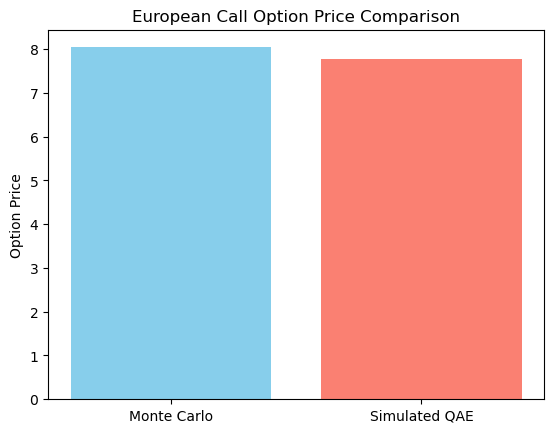

In [19]:
import matplotlib.pyplot as plt

prices = [mc_price, qae_price]
labels = ["Monte Carlo", "Simulated QAE"]

plt.bar(labels, prices, color=['skyblue', 'salmon'])
plt.ylabel("Option Price")
plt.title("European Call Option Price Comparison")
plt.show()


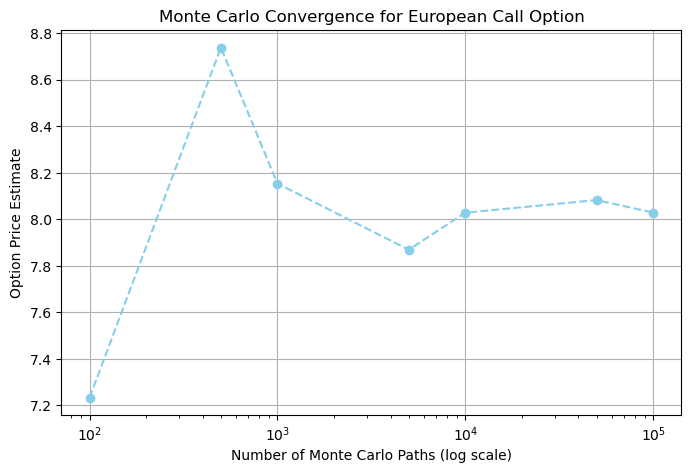

In [21]:
# Monte Carlo convergence
n_paths_list = [100, 500, 1000, 5000, 10000, 50000, 100000]
mc_estimates = []

for n in n_paths_list:
    pricer = MonteCarloPricer(S0, K, T, r, sigma, n_simulations=n)
    mc_estimates.append(pricer.simulate())

plt.figure(figsize=(8,5))
plt.plot(n_paths_list, mc_estimates, marker='o', linestyle='--', color='skyblue')
plt.xscale('log')
plt.xlabel("Number of Monte Carlo Paths (log scale)")
plt.ylabel("Option Price Estimate")
plt.title("Monte Carlo Convergence for European Call Option")
plt.grid(True)
plt.show()


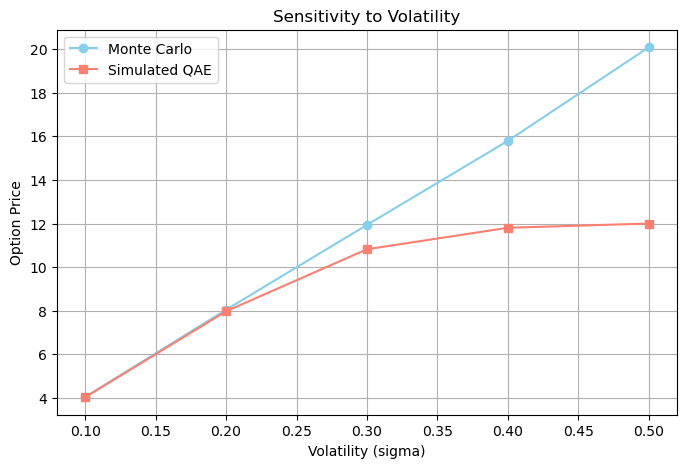

In [25]:
# Sensitivity to volatility
sigma_values = np.linspace(0.1, 0.5, 5)
mc_prices_sigma = []
qae_prices_sigma = []

for sigma_i in sigma_values:
    mc_pricer = MonteCarloPricer(S0, K, T, r, sigma_i, n_simulations=100000)
    mc_prices_sigma.append(mc_pricer.simulate())

    qae_pricer = SimulatedQAEPricer(S0, K, T, r, sigma_i, num_qubits=8)
    qae_prices_sigma.append(qae_pricer.price())

plt.figure(figsize=(8,5))
plt.plot(sigma_values, mc_prices_sigma, marker='o', label='Monte Carlo', color='skyblue')
plt.plot(sigma_values, qae_prices_sigma, marker='s', label='Simulated QAE', color='salmon')
plt.xlabel("Volatility (sigma)")
plt.ylabel("Option Price")
plt.title("Sensitivity to Volatility")
plt.legend()
plt.grid(True)
plt.show()


# Appendix: Analytical Derivation and Computational Advantage

## 1. European Call Option Pricing Derivation

Consider a European call option with:

- Current stock price: $S_0$
- Strike price: $K$
- Risk-free rate: $r$
- Volatility: $\sigma$
- Time to maturity: $T$

Under the **Black-Scholes assumptions**, the stock price at maturity $S_T$ follows a log-normal distribution:

$$
S_T = S_0 \exp\Big((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z\Big), \quad Z \sim \mathcal{N}(0,1)
$$

The price of the European call option is the discounted expected payoff:

$$
C = e^{-rT} \mathbb{E}[\max(S_T - K, 0)]
$$

Substituting $S_T$:

$$
C = e^{-rT} \int_0^\infty \max(S_T - K, 0) f_{S_T}(S_T) \, dS_T
$$

where $f_{S_T}$ is the log-normal density:

$$
f_{S_T}(S_T) = \frac{1}{S_T \sigma \sqrt{2\pi T}} \exp\Bigg(-\frac{\big(\ln(S_T/S_0) - (r - \frac{1}{2}\sigma^2)T\big)^2}{2\sigma^2 T}\Bigg)
$$

Solving this integral gives the **Black-Scholes formula**:

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

with

$$
d_1 = \frac{\ln(S_0/K) + (r + \frac{1}{2}\sigma^2) T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$

and $N(\cdot)$ is the standard normal CDF.

---

## 2. Computational Efficiency: Monte Carlo vs. QAE

### Classical Monte Carlo

Monte Carlo estimates the expected payoff:

$$
\hat{C}_{MC} = e^{-rT} \frac{1}{N} \sum_{i=1}^{N} \max(S_T^{(i)} - K, 0)
$$

- Statistical error: $\epsilon_{MC} \sim \sigma_\text{payoff}/\sqrt{N}$
- To achieve error $\epsilon$: $N \sim \mathcal{O}(1/\epsilon^2)$
- High precision requires many samples → high computational cost.

### Quantum Amplitude Estimation (QAE)

QAE estimates the expected payoff using **quantum amplitude encoding**:

$$
\epsilon_{QAE} \sim \frac{1}{M}
$$

- $M$ = number of quantum circuit evaluations
- To achieve error $\epsilon$: $M \sim \mathcal{O}(1/\epsilon)$
- Quadratic speedup over classical Monte Carlo.

| Method | Samples / Evaluations for error $\epsilon$ |
|--------|-------------------------------------------|
| Classical Monte Carlo | $\mathcal{O}(1/\epsilon^2)$ |
| Quantum Amplitude Estimation | $\mathcal{O}(1/\epsilon)$ |

### Implications

- For high-precision pricing, QAE requires **far fewer samples** than classical Monte Carlo.
- Simulated QAE can be used to validate methods without quantum hardware.
- Promising for large portfolios and multi-asset pricing as quantum technology matures.

